<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:
# Student 1:
# Student 2:
# Student 3:

In case you are using google colab, uncomment the following cell, and modify the ```notebook_dir``` variable to contain the directory this notebook is in. It will automatically download the .py files needed for this assignment

In [1]:
# # Change the following  line to the directory this notebook is (if using colab)
# # In case you do not know the path, open the file navigator on the left in colab
# # Find the folder containing this notebook, then press on the three dots --> copy path
# notebook_dir = "/content/drive/MyDrive/Colab Notebooks/"

In [2]:
# # UNCOMMENT IF USING COLAB
# from google.colab import drive
# import requests
# drive.mount('/content/drive')
# import sys
# import os
# sys.path.insert(0, notebook_dir) 
# os.chdir(notebook_dir)
# symco = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/symconv.py?raw=true"
# crpt = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/carpet.py?raw=true"
# r_s = requests.get(symco, allow_redirects=True)
# r_c = requests.get(crpt, allow_redirects=True)
# with open('symconv.py', 'wb') as f:
#     f.write(r_s.content)
# with open('carpet.py', 'wb') as f:
#     f.write(r_c.content)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import io
import requests

import symconv as sc
from carpet import show_carpet, oh_to_label

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from tqdm import tqdm

In [2]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 

# Task 1: Pattern Classification

In [3]:
# loading training and testing data for task 1
# DO NOT MODIFY
task1 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task1data.npz?raw=true")
# task1 = np.load("task1data.npz")

X = torch.tensor(task1['arr_0']).float()
y = torch.tensor(task1['arr_1']).float()

X_train = X[:7500]
X_val = X[7500:9500]
X_test = X[9500:]
y_train = y[:7500]
y_val = y[7500:9500]
y_test  = y[9500:]

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


print(f"Carpet train shape: {X_train.shape}")
print(f"Label train shape: {y_train.shape}")
print(f"Carpet validation shape: {X_val.shape}")
print(f"Label validation shape: {y_val.shape}")
print(f"Carpet test shape: {X_test.shape}")
print(f"Label test shape: {y_test.shape}")

Carpet train shape: torch.Size([7500, 1, 96, 60])
Label train shape: torch.Size([7500, 3])
Carpet validation shape: torch.Size([2000, 1, 96, 60])
Label validation shape: torch.Size([2000, 3])
Carpet test shape: torch.Size([500, 1, 96, 60])
Label test shape: torch.Size([500, 3])


Carpet from Transformabad


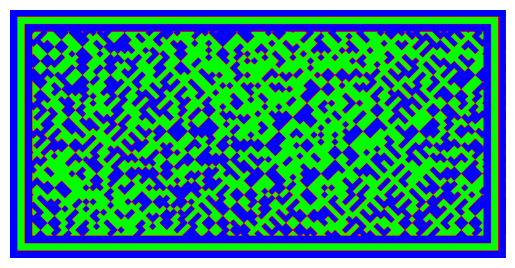

In [4]:
# random carpet
idx = np.random.randint(0,7500)
show_carpet(X_train, idx)
print('Carpet from', oh_to_label(y_train[idx,None])[0])

In [5]:
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

def train_model(train_dataset, val_dataset, model, num_epochs, learning_rate=0.001, batch_size=64, device='cuda'):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)

    for epoch in range(num_epochs):
        model.train()

        train_loss = 0
        train_correct = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch_indices = torch.argmax(y_batch, axis=1)  # Convert one-hot to indices

            output = model(X_batch)
            loss = criterion(output, y_batch_indices)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = output.max(1)
            train_correct += predicted.eq(y_batch_indices).sum().item()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_acc = train_correct / len(train_dataset)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_correct = 0
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_batch_indices = torch.argmax(y_batch, axis=1)  # Convert one-hot to indices

                output = model(X_batch)
                loss = criterion(output, y_batch_indices)

                _, predicted = output.max(1)
                val_correct += predicted.eq(y_batch_indices).sum().item()
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_dataset)

        print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Train Acc: {train_acc:.6f}, Val Loss: {val_loss:.6f}, Val Acc: {val_acc:.6f}')


In [8]:
from symconv import Slice, SymmetryConv2d, SymmetryPool

class SymmetryCNN(nn.Module):
    def __init__(self, n_classes=3):
        super(SymmetryCNN, self).__init__()
        
        # unit cell (4-fold rotation), 18 filters (18 different unit cells)
        self.slice4 = Slice(rotation=4, reflection=False)
        self.conv1 = SymmetryConv2d(in_filters=1, out_filters=18, kernel_size=4, stride=4, rotation=4, reflection=False)

        # super cell (1-fold rotation), 12 filters (12 different super cells)
        self.slice1 = Slice(rotation=1, reflection=False)
        self.conv2 = SymmetryConv2d(in_filters=18, out_filters=12, kernel_size=3, stride=3, rotation=1, reflection=False)

        self.relu = nn.ReLU()
        self.pool = SymmetryPool()

        # Classifier head
        self.fc1 = nn.Linear(480, 256)
        self.fc2 = nn.Linear(256, n_classes)

    def forward(self, x):
        # Unit cell
        x = self.slice4(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Super cell (NO ROTATION)
        x = self.slice1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x) # 8x5 activations  

        # Classifier head
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

# train the model
train_model(train_dataset, val_dataset, SymmetryCNN(), num_epochs=10, learning_rate=0.001, batch_size=64, device = "mps")

Epoch: 1/10, Train Loss: 3.343991, Train Acc: 0.341200, Val Loss: 1.158463, Val Acc: 0.361000
Epoch: 2/10, Train Loss: 1.135296, Train Acc: 0.394000, Val Loss: 1.044793, Val Acc: 0.485500
Epoch: 3/10, Train Loss: 0.926303, Train Acc: 0.552533, Val Loss: 0.847589, Val Acc: 0.610500
Epoch: 4/10, Train Loss: 0.614667, Train Acc: 0.766800, Val Loss: 0.437596, Val Acc: 0.911000
Epoch: 5/10, Train Loss: 0.307250, Train Acc: 0.928000, Val Loss: 0.238255, Val Acc: 0.946500
Epoch: 6/10, Train Loss: 0.150831, Train Acc: 0.971867, Val Loss: 0.105246, Val Acc: 0.980000
Epoch: 7/10, Train Loss: 0.075156, Train Acc: 0.992000, Val Loss: 0.070608, Val Acc: 0.993500
Epoch: 8/10, Train Loss: 0.039858, Train Acc: 0.996933, Val Loss: 0.048809, Val Acc: 0.992000
Epoch: 9/10, Train Loss: 0.027645, Train Acc: 0.998933, Val Loss: 0.035172, Val Acc: 0.996000
Epoch: 10/10, Train Loss: 0.018759, Train Acc: 0.999467, Val Loss: 0.027123, Val Acc: 0.998000


## Task 1: Question 5d

# Task 2: Carpet Matching 

In [ ]:
# loading training and testing data for task 2
# DO NOT MODIFY
task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
# task2 = np.load('task2data.npz')

X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(float)
gt = task2['arr_2'].astype(float) # ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

print(f"Carpet train shape: {X.shape}")
print(f"Label train shape: {y.shape}")
print(f"Ground truth test shape: {gt.shape}")
print(f"Query carpets shape: {queries.shape}")
print(f"Candidate carpets shape: {targets.shape}")

In [ ]:
# function to determine performance of model
def query_performance(queries, targets, gt, top=1):
    assert top >= 1
    cnt = 0
    for i in range(gt.shape[0]):

        q = queries[i][None].float().cuda()
        t = targets[i].float().cuda()

        with torch.no_grad():
            
            
            ### MODIFY IF NECESSARY ###
            emb_q = net(q).cpu().numpy()
            emb_t = net(t).cpu().numpy()

            dists = cdist(emb_q, emb_t)
            
            if top == 1:
                pred = np.argmin(dists)

                if pred == gt[i]:
                    cnt += 1
            
            else:
                pred = np.argsort(dists)
                if gt[i] in pred[0,:top].tolist():
                    cnt+=1
    return (100*cnt/gt.shape[0])

In [ ]:
###     YOUR CODE FOR TASK 2    ###
### ADD MORE CELLS IF NECESSARY ###